In [1]:
import os
import pyvips
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import pandas as pd
import glob
from tqdm.auto import tqdm
from joblib import Parallel, delayed

os.environ['VIPS_DISC_THRESHOLD'] = '10gb'

# Params
seed = 42
drop_thr = 0.60
size = 1024
scale = 0.5

# Paths
root = '/media/latlab/MR/projects/kaggle-ubc-ocean'
data_dir = os.path.join(root, 'data')
results_dir = os.path.join(root, 'results')
train_csv = 'train.csv'
train_image_dir = os.path.join(data_dir, 'train_images')
train_mask_dir = os.path.join(data_dir, 'train_masks')
train_thumbnail_dir = os.path.join(data_dir, 'train_thumbnails')
out_dir = os.path.join(results_dir, f'tumor_detection_tiles_{size}_p{int(scale*100)}_drop{int(drop_thr*100)}')

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

def extract_image_tiles(p_img, p_mask, folder, size: int = 2048, scale: float = 0.25, drop_thr: float = 0.85) -> list:
    im = pyvips.Image.new_from_file(p_img)
    mask = pyvips.Image.new_from_file(p_mask)
    assert (mask.width, mask.height) == (im.width, im.height)
    w = h = size

    # Tiling
    files = []
    valid_idx_list = []
    background_label_list = []
    tumor_label_list = []
    stroma_label_list = []
    necrosis_label_list = []
    idxs = [(y, y + h, x, x + w) for y in range(0, im.height, h) for x in range(0, im.width, w)]
    for k, (y, y_, x, x_) in enumerate(idxs):
        tile = im.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3]
        tile_labels = mask2label(mask.crop(x, y, min(w, im.width - x), min(h, im.height - y)).numpy()[..., :3])

        # Pad if necessary
        if tile.shape[:2] != (h, w):
            tile_ = tile
            tile_size = (h, w) if tile.ndim == 2 else (h, w, tile.shape[2])
            tile = np.zeros(tile_size, dtype=tile.dtype)
            tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
            
            tile_labels_ = tile_labels
            tile_labels = np.zeros(tile_size[:2], dtype=tile_labels.dtype)
            tile_labels[:tile_labels_.shape[0], :tile_labels_.shape[1]] = tile_labels_
        
        # Drop background tiles
        mask_bg = np.sum(tile, axis=2) == 0
        if np.sum(mask_bg) >= (np.prod(mask_bg.shape) * drop_thr):
            continue

        # Get mask
        pix_num = np.prod(tile_labels.shape)
        background_label_list.append(np.sum(tile_labels == 0)/pix_num)
        tumor_label_list.append(np.sum(tile_labels == 1)/pix_num)
        stroma_label_list.append(np.sum(tile_labels == 2)/pix_num)
        necrosis_label_list.append(np.sum(tile_labels == 3)/pix_num)
        
        p_img = os.path.join(folder, f"{k:06}_{int(x_ / w)}-{int(y_ / h)}.png")
        new_size = int(size * scale), int(size * scale)
        Image.fromarray(tile).resize(new_size, Image.LANCZOS).save(p_img)
        files.append(p_img)
        valid_idx_list.append((y, y_, x, x_))
    
    # Handle labels table
    img_id_list = [os.path.splitext(os.path.basename(p))[0] for p in files]
    labels = pd.DataFrame({'image_id': img_id_list, 'tumor': tumor_label_list, 'stroma': stroma_label_list, 'necrosis': necrosis_label_list, 'background': background_label_list})
    labels.to_csv(os.path.join(folder, 'labels.csv'), index=False)
    return files, valid_idx_list, im.height, im.width, labels

def extract_prune_tiles(idx_path_img, image_dir, mask_dir, folder, size: int, scale: float, drop_thr: float) -> None:
    idx, image_id = idx_path_img
    print(f"processing #{idx}: {image_id}")
    folder = os.path.join(folder, str(image_id))
    p_img = os.path.join(image_dir, f'{image_id}.png')
    p_mask = os.path.join(mask_dir, f'{image_id}.png')
    os.makedirs(folder, exist_ok=True)
    tiles, _, _, _, _ = extract_image_tiles(p_img, p_mask, folder, size, scale, drop_thr)

def mask2label(mask: np.ndarray):
    """
    modify the color mask to label mask in place.

    Args:
        mask: (H, W), np.uint8

    Returns:
        mask: (H, W), np.uint8, value: {'background': 0, 'tumor': 1, 'stroma': 2, 'necrosis': 3}
    """
    bg = (mask.sum(axis=-1) == 0)
    mask = mask.argmax(axis=-1).astype(np.uint8) + 1
    mask[bg] = 0

    return mask

# Load data
df = pd.read_csv(os.path.join(data_dir, train_csv))

# Get only images with masks
mask_id_list = [int(os.path.splitext(os.path.basename(mask_path))[0]) for mask_path in glob.glob(os.path.join(train_mask_dir, '*.png'))]
df = df[df['image_id'].isin(mask_id_list)].reset_index(drop=True)
df

,image_id,label,image_width,image_height,is_tma
0,66,LGSC,48871,48195,False
1,1020,HGSC,36585,33751,False
2,1101,HGSC,26306,18403,False
3,1252,HGSC,60420,27480,False
4,1925,HGSC,44847,32951,False
...,...,...,...,...,...
147,63165,CC,30342,12783,False
148,63941,HGSC,47123,36600,False
149,65022,LGSC,53355,46675,False
150,65094,MC,55042,45080,False


## Show the image tiles with segmentations for one test image

In [2]:
# test_img_id = '1101'
# test_img_id = '4'

# show_mask = True

# os.makedirs('/tmp/ubc', exist_ok=True)
# tiles_img, idx_list, img_height, img_width, labels = extract_image_tiles(
#     os.path.join(train_image_dir, f'{test_img_id}.png'), 
#     os.path.join(train_mask_dir, f'{test_img_id}.png'),
#     '/tmp/ubc', size=size, scale=scale, drop_thr=drop_thr)
# print(len(tiles_img))

# fig = plt.figure(figsize=(16, 20))
# ax = plt.gca()
# for p_img, (y, y_, x, x_) in zip(tiles_img, idx_list):
#     img = plt.imread(p_img)
#     ax.imshow(img, extent=(x, x+size, img_height-y-size, img_height-y), alpha=0.5, interpolation='none')
# print(f"image size: {img.shape}")

# # Mask
# if show_mask:
#     mask = plt.imread(os.path.join(train_mask_dir, f'{test_img_id}.png'))
#     ax.imshow(mask, alpha=0.2, extent=(0, img_width, 0, img_height), interpolation='none')

# plt.xlim(0, img_width)
# plt.ylim(0, img_height)

## Export all image tiles¶

In [3]:
os.makedirs(out_dir, exist_ok=True)
ls = df.image_id.tolist()
print(f"found images: {len(ls)}")

    
_= Parallel(n_jobs=4)(
    delayed(extract_prune_tiles)
    (image_id, train_image_dir, train_mask_dir, out_dir, size=size, drop_thr=drop_thr, scale=scale)
    for image_id in tqdm(enumerate(ls), total=len(ls))
)
# for image_id in tqdm(enumerate(ls), total=len(ls)):
#     extract_prune_tiles(image_id, train_image_dir, train_mask_dir, out_dir, size=size, drop_thr=drop_thr, scale=scale)

found images: 152


  0%|          | 0/152 [00:00<?, ?it/s]

processing #0: 66
processing #3: 1252
processing #2: 1101
processing #1: 1020
processing #4: 1925
processing #5: 1952
processing #6: 2227
processing #7: 2666
processing #8: 4211
processing #9: 4797
processing #10: 4963
processing #11: 5251
processing #12: 5851
processing #13: 5852
processing #14: 5992


/home/latlab/anaconda3/envs/ubc-ocean/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


processing #15: 6281
processing #16: 6558
processing #17: 6898
processing #18: 6951
processing #19: 7329
processing #20: 8279
processing #21: 8531
processing #22: 9183
processing #23: 9658
processing #24: 9697
processing #25: 10143
processing #26: 10246
processing #27: 10252
processing #28: 10800
processing #29: 10896
processing #30: 11263
processing #31: 11431
processing #32: 11557
processing #33: 12442
processing #34: 12522
processing #35: 13987
processing #36: 14401
processing #37: 14424
processing #38: 14542
processing #39: 15139
processing #40: 15188
processing #41: 15209
processing #42: 15470
processing #43: 15486
processing #44: 15671
processing #45: 16064
processing #46: 16325
processing #47: 16876
processing #48: 16986
processing #49: 17174
processing #50: 17291
processing #51: 17738
processing #52: 17854
processing #53: 18138
processing #54: 18568
processing #55: 18607
processing #56: 19030
processing #57: 19255
processing #58: 19569
processing #59: 20316
processing #60: 2143

## Show some samples

found folders: 152
found images: 158656


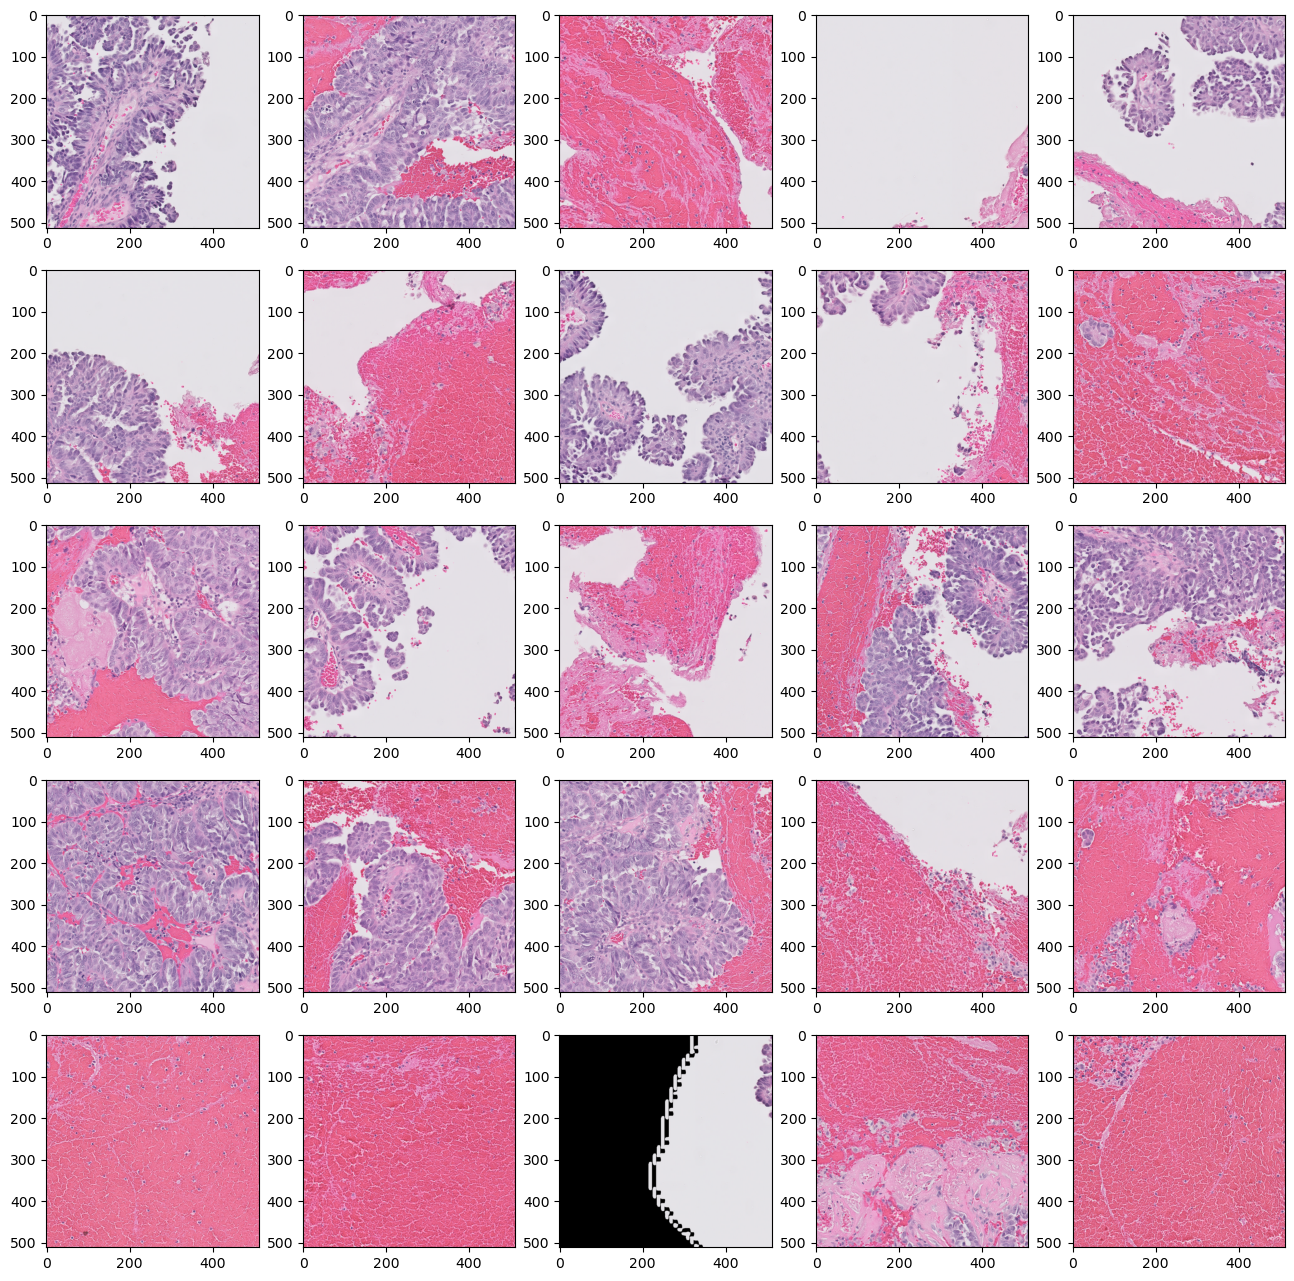

In [4]:
ls = [p for p in glob.glob(out_dir + '/*') if os.path.isdir(p)]
print(f"found folders: {len(ls)}")
ls = glob.glob(out_dir + '/*/*.png')
print(f"found images: {len(ls)}")

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
for i, p_img in enumerate(ls[:25]):
    img = plt.imread(p_img)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)